In [52]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

# The case for Survival Analysis

In [53]:
def mean_absolute_error(y_true, y_pred):
    return np.abs(y_true-y_pred).mean()

In [54]:
# load the data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
z_train = np.load('z_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
z_test = np.load('z_test.npy')


In [55]:
print('Number of training samples:', X_train.shape[0])
print('Number of features per sample:', X_train.shape[1])
print('Number of test samples:', X_test.shape[0])
print('Observed survival time: max {}, min {}:'.format(y_train.max(), y_train.min()))

Number of training samples: 3521
Number of features per sample: 15
Number of test samples: 3522
Observed survival time: max 72, min 0:


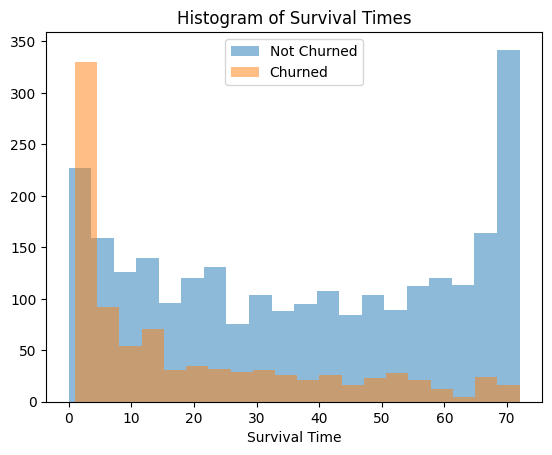

In [56]:
plt.hist(y_train[z_train==0], bins = 20, alpha=0.5, label='Not Churned')
plt.hist(y_train[z_train==1], bins = 20, alpha=0.5, label='Churned')
plt.legend()
plt.xlabel('Survival Time')
plt.title('Histogram of Survival Times');

In [57]:
# metrics for evaluation
def plot_results(y, prediction, z, save=False):
    plt.figure(figsize=(20,8))
    plt.subplot(131)
    plt.scatter(prediction, y, s=1)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.plot([0,70],[0,70], color='C1')
    plt.title(f'MAE {mean_absolute_error(y, prediction)}')

    plt.subplot(132)
    plt.scatter(prediction[z==1], y[z==1], s=1)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.plot([0,70],[0,70], color='C1')
    plt.title(f'MAE (Churned) {mean_absolute_error(y[z==1], prediction[z==1])}')

    plt.subplot(133)
    plt.scatter(prediction[z==0], y[z==0], s=1)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.plot([0,70],[0,70], color='C1')
    plt.title(f'MAE (Not Churned) {mean_absolute_error(y[z==0], prediction[z==0])}');
    if save:
        plt.tight_layout()
        timestamp = time.time()
        plt.savefig(f'comparison_{timestamp}.pdf')
        print(f'saved as comparison_{timestamp}.pdf')
    plt.show()
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.hist((y-prediction)[z==0]);
    plt.xlabel('y-f(x)')
    plt.title('Error if not Churned')
    plt.gca().axvline(x=0, color='grey', linewidth=1)
    plt.subplot(122)
    plt.hist((y-prediction)[z==1]);
    plt.xlabel('y-f(x)')
    plt.title('Error if Churned')
    plt.gca().axvline(x=0, color='grey', linewidth=1)
    if save:
        plt.tight_layout()
        timestamp = time.time()
        plt.savefig(f'error_{timestamp}.pdf')
        print(f'saved as error_{timestamp}.pdf')
    plt.show()
    
def compute_metrics(y, prediction, z):
    died_p = np.array(prediction[z==1])
    died_y = np.array(y[z==1])
    cindex = ((np.expand_dims(died_y,0)<=np.expand_dims(y,1))&(np.expand_dims(died_p,0)<=np.expand_dims(prediction,1))).sum()/(np.expand_dims(died_y,0)<=np.expand_dims(y,1)).sum()
    print(f'C-Index: {cindex}')
    underestimated = np.mean((prediction-y)[(prediction<y)&(z==1)])
    print(f'Average Underestimated Survival (Churned): {-underestimated}')
    underestimated = np.mean((prediction-y)[(prediction<y)&(z==0)])
    print(f'Average Underestimated Survival (Not Churned): {-underestimated}')

# Linear Survival SVM

In [58]:
# get data, which is comparable: for a given y_i, return X_j(i), y_j(i)
def get_comparable_data(y):
    comparable_y = np.max(observed_y[observed_y<y])
    idx = np.random.randint((observed_y==comparable_y).sum())
    return observed_X[observed_y==comparable_y][idx], observed_y[observed_y==comparable_y][idx]

In [59]:
# define y_comp, y_comp_bar: 
# y_comp = y_i for (i,j)in E
# y_comp_bar = y_j for (i,j)in E
# define X_comp, X_comp_bar: 
# X_comp = x_i for (i,j) in E
# X_comp_bar = x_j for (i,j) in E

observed_X = X_train[z_train==1]
observed_y = y_train[z_train==1]

y_comp = y_train[y_train>1]
X_comp = X_train[y_train>1]
data_comp_bar = list(map(get_comparable_data, y_comp))

X_comp_bar = np.vstack([dcb[0] for dcb in data_comp_bar])
y_comp_bar = np.hstack([dcb[1] for dcb in data_comp_bar])

In [66]:
# Construct matrix U, V, W, delta_y
U = (X_comp - X_comp_bar) @ (X_comp - X_comp_bar).T
V = X_train @ (X_train.T)
W = X_train @ (X_comp - X_comp_bar).T
delta_y = y_comp - y_comp_bar

In [67]:
Q = np.block([
    [U, W.T],
    [W, V]
])

In [68]:
Q.shape

(6730, 6730)

In [69]:
# Constant in the problem
n = X_train.shape[0]
E = y_comp.shape[0]
r_1 = 100 / E
r_2 = 10000 / n

In [70]:
### YOUR CODE HERE
# construct a diagonal Z matrix
Z = np.diag(z_train)

# quadratic program setup
alpha = cp.Variable(E)
beta = cp.Variable(n)
gamma = cp.Variable(n)
# initialize constraints
constraints = []
tolerance = 1e-12


constraints.append(cp.abs(cp.sum(beta-Z@gamma)) <= tolerance)

# add constraints for alpha
for i in range(E):
    constraints.append(alpha[i]>=tolerance)
    constraints.append(alpha[i]<=r_1)
    
# add constraints for beta and gamma
for i in range(n):  
    constraints.append(beta[i]>=tolerance)
    constraints.append(beta[i]<=r_2)
    constraints.append(gamma[i]>=tolerance)
    constraints.append(gamma[i]<=r_2)



### FORMULATE AND SOLVE DM
x = cp.hstack([alpha, beta - Z@gamma])

dy_y = np.hstack([delta_y, y_train])
objective = -cp.quad_form(x, cp.atoms.affine.wraps.psd_wrap(Q)) + dy_y.T @ x

objective = cp.Maximize(objective)

In [71]:
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=1)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 23 08:19:39 PM: Your problem has 10251 variables, 20503 constraints, and 0 parameters.
(CVXPY) Nov 23 08:19:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 23 08:19:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 23 08:19:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 23 08:19:40 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 23 08:19:40 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr

53090.764795320814

In [72]:
print('optimal objective value:')
opt_objective = objective.value
print(opt_objective)

optimal objective value:
53090.764795320814


In [73]:
alpha = alpha.value
gamma = gamma.value
beta = beta.value

In [74]:
idx = np.logical_or(beta > tolerance, np.logical_and(gamma >tolerance, z_train==1))
idx.sum()

2279

In [79]:
# remove X_i from X_comp if X_i is in the X_train[idx]
X_comp_process = []
X_comp_bar_process = []
alpha_process = []
# check = []

for i in range(X_comp.shape[0]):
    if any(np.array_equal(X_comp[i], x) for x in X_train[idx]):
        # check.append(i)
        X_comp_process.append(X_comp[i])
        X_comp_bar_process.append(X_comp_bar[i])
        alpha_process.append(alpha[i])
X_comp_process = np.array(X_comp_process)
X_comp_bar_process = np.array(X_comp_bar_process)
alpha_process = np.array(alpha_process)
        

In [80]:
# omega = omega_1 + omega_2
# process beta and gamma and map value lower than tolerance to 0
# for ind, val in enumerate(beta):
#     if abs(val) < tolerance:
#         beta[ind] = 0
# for ind, val in enumerate(gamma):
#     if abs(val) < tolerance:
#         gamma[ind] = 0
# omega_1 = alpha.dot(X_comp - X_comp_bar)
Z_process = Z[:, idx][idx, :]
omega_1 = alpha_process.dot(X_comp_process - X_comp_bar_process)
omega_2 = (beta[idx] - Z_process@gamma[idx]).dot(X_train[idx])
omega = omega_1 + omega_2
print('omega in the regression is:')
omega

omega in the regression is:


array([-0.88242752,  0.67702733,  3.03969429,  0.21356588, -2.25762032,
        3.04961088, -3.82063888,  2.43172479,  2.87672704,  1.74867553,
        1.655557  ,  1.74284319,  2.05472356,  1.07029697,  9.43892382])

In [75]:
omega_1 = alpha.dot(X_comp - X_comp_bar)
omega_2 = (beta - Z@gamma).dot(X_train)
omega = omega_1 + omega_2
print('omega in the regression is:')
omega

omega in the regression is:


array([-0.48988696,  0.33886583,  2.22881779,  0.07787463, -1.40106462,
        2.5461383 , -4.4929384 ,  2.29338347,  2.50299425,  1.20179907,
        1.01424074,  0.45713374,  0.52542538, -0.02428915,  9.00126517])

In [82]:
### YOUR CODE HERE
b = (y_train[idx] - X_train[idx] @ omega).mean()
prediction = b + X_train @ omega
### FIND THE PREDICTION ON THE TRAINING SET

In [83]:
# unique, counts = np.unique(b, return_counts=True)
# unique, counts
b

37.12978369935541

Training Performance
saved as comparison_1669231336.661694.pdf


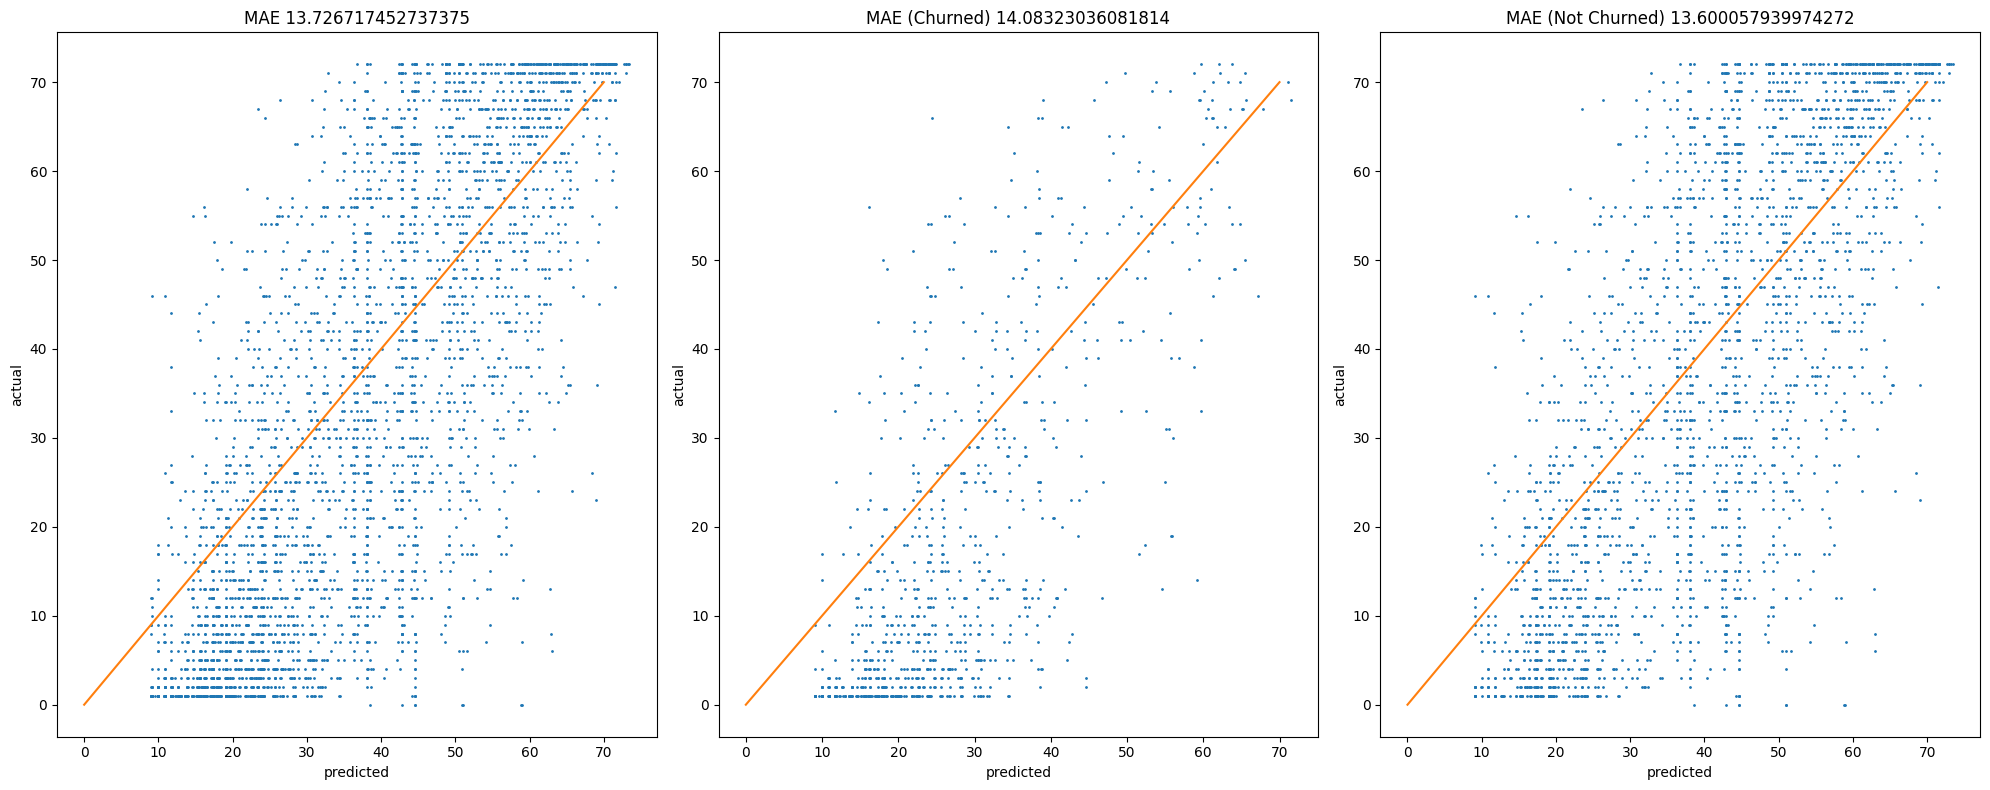

saved as error_1669231337.048954.pdf


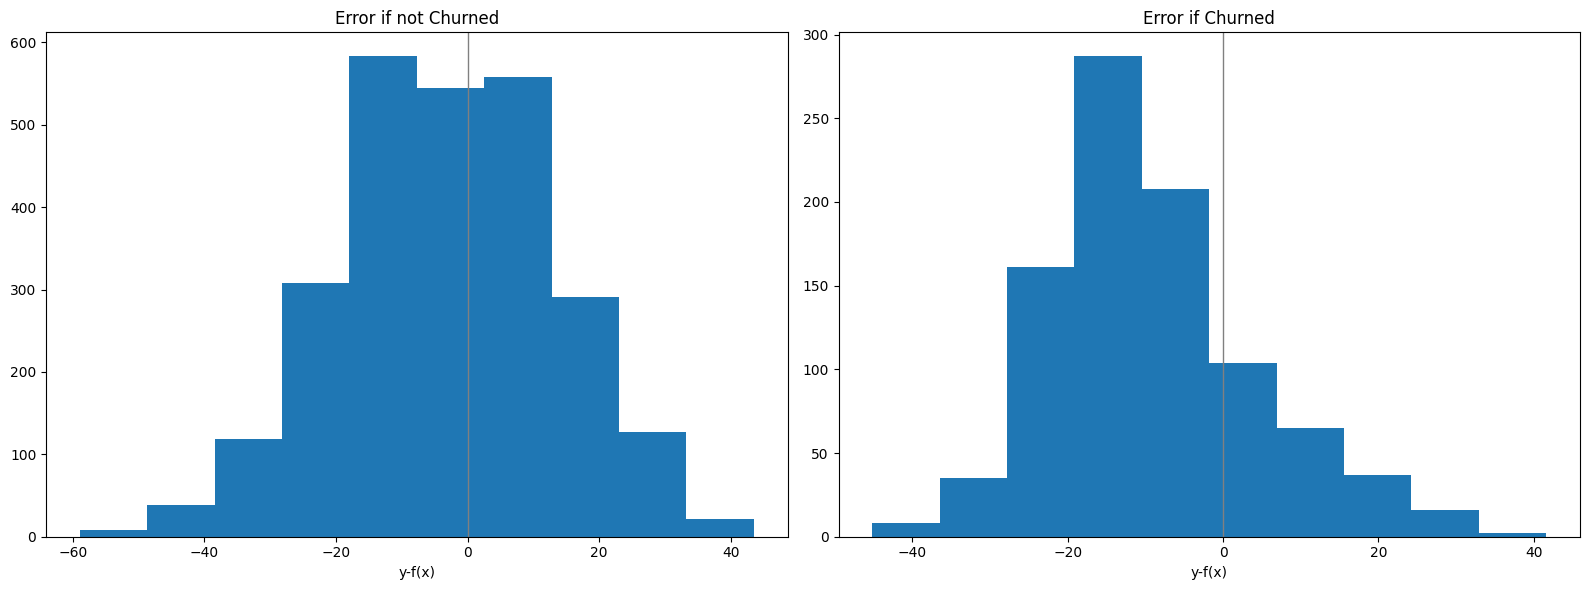

C-Index: 0.8322728875472979
Average Underestimated Survival (Churned): 11.354690540618604
Average Underestimated Survival (Not Churned): 11.807459725352993


In [84]:
print('Training Performance')
# plot the training performance
plot_results(y_train, prediction, z_train, save=True)
compute_metrics(y_train,prediction, z_train)

In [85]:
### YOUR CODE HERE
prediction = b + X_test @ omega
### FIND THE PREDICTION ON THE TEST SET

Testing Performance
saved as comparison_1669231359.012508.pdf


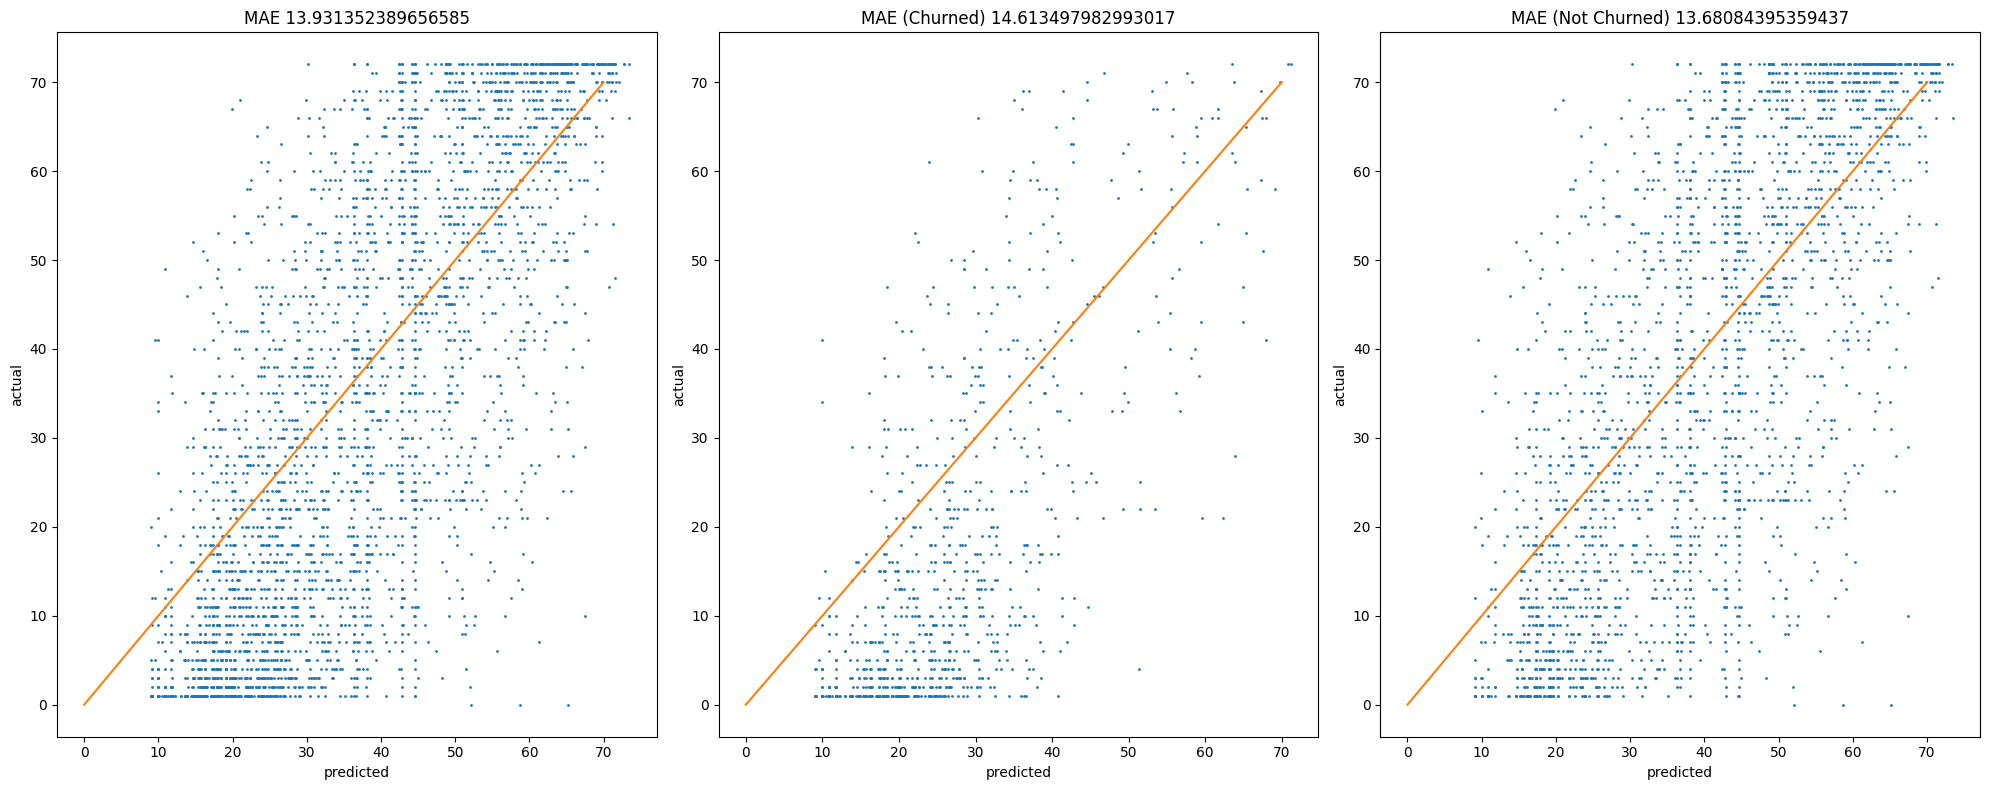

saved as error_1669231359.407959.pdf


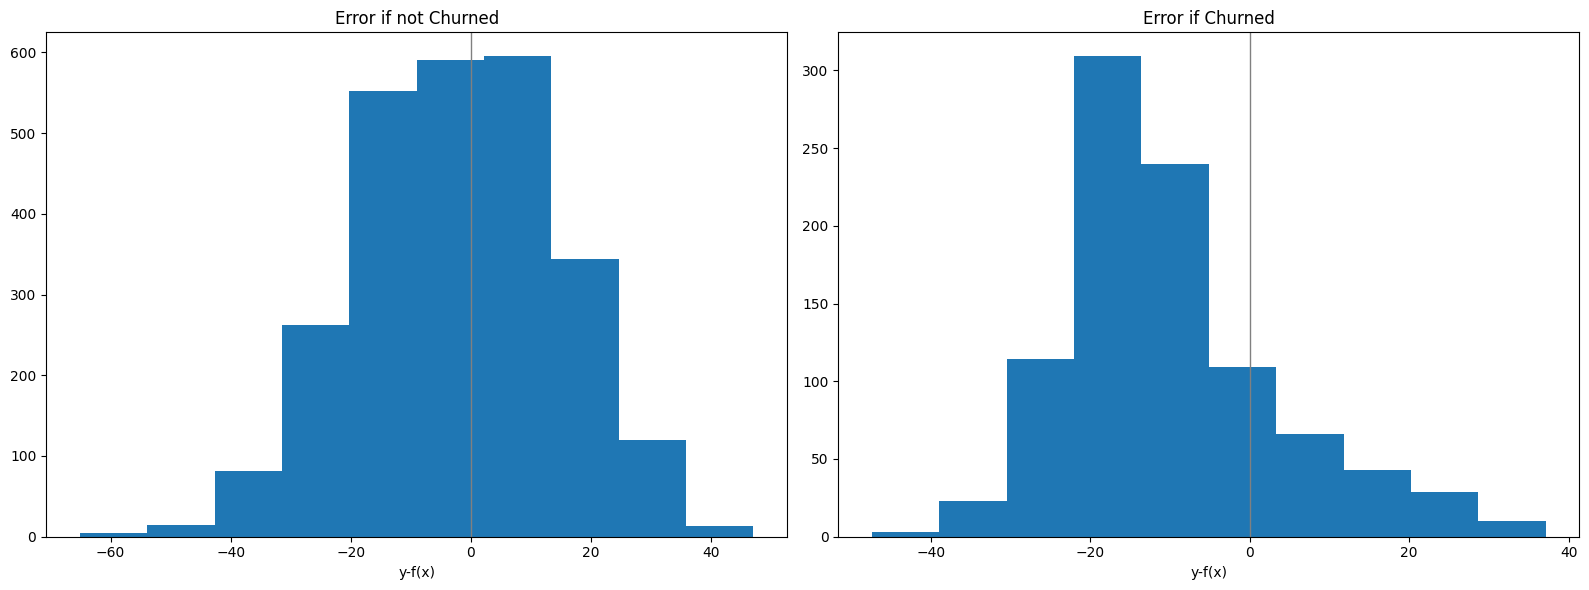

C-Index: 0.8267104852133801
Average Underestimated Survival (Churned): 11.508704094217295
Average Underestimated Survival (Not Churned): 12.292210985735371


In [86]:
print('Testing Performance')
# plot the test performance
plot_results(y_test, prediction, z_test, save=True)
compute_metrics(y_test, prediction, z_test)

# Simple MAE Regression

In [31]:
### YOUR CODE HERE
# extract the dimensionality (number of features)
d = X_train.shape[1]

w = cp.Variable(15)
b = cp.Variable(1)

### FORMULATE AND SOLVE DM
objective = 0.5 * cp.quad_form(w, np.eye(d)) + r_2 * cp.sum( cp.abs( y_train - X_train @ w.T - b ) )
prob = cp.Problem(cp.Minimize(objective))
prob.solve(solver=cp.MOSEK, verbose=True)
### SOLVE THE MAE REGRESSION PROBLEM

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 23 08:06:20 PM: Your problem has 16 variables, 0 constraints, and 0 parameters.
(CVXPY) Nov 23 08:06:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 23 08:06:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 23 08:06:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 23 08:06:20 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 23 08:06:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

119805.10029304489

In [32]:
### YOUR CODE HERE
prediction_reg = X_train @ w.value.T + b.value
### FIND THE PREDICTION ON THE TRAINING SET

Training Performance
saved as comparison_1669230380.263586.pdf


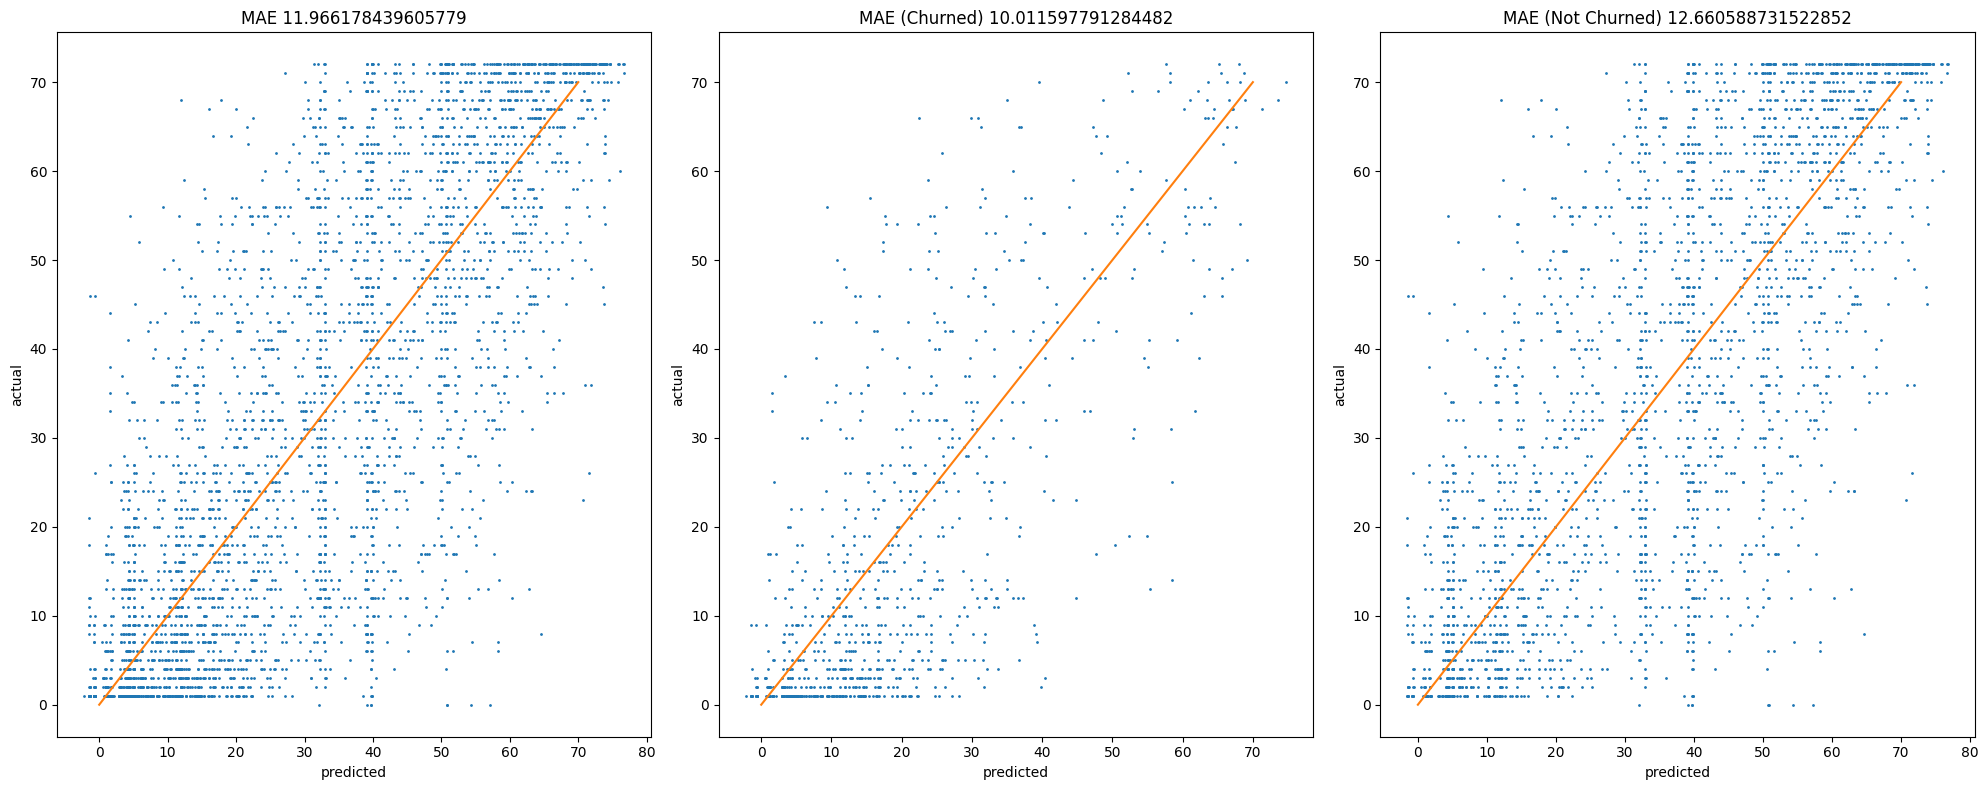

saved as error_1669230380.655936.pdf


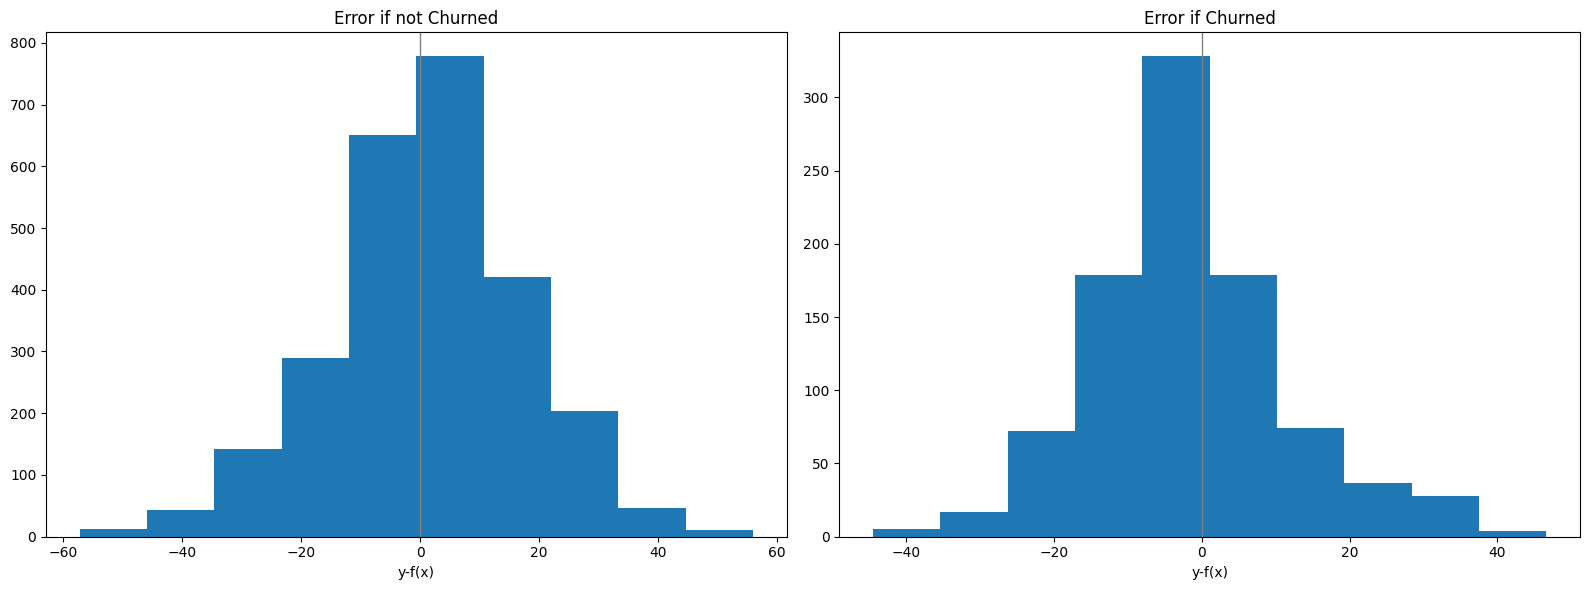

C-Index: 0.82914098699338
Average Underestimated Survival (Churned): 10.611452187969656
Average Underestimated Survival (Not Churned): 12.918426948857409


In [33]:
print('Training Performance')
plot_results(y_train, prediction_reg, z_train, save=True)
compute_metrics(y_train, prediction_reg, z_train)

In [34]:
### YOUR CODE HERE
prediction_reg = X_test @ w.value.T + b.value
### FIND THE PREDICTION ON THE TESTING SET

Testing Performance


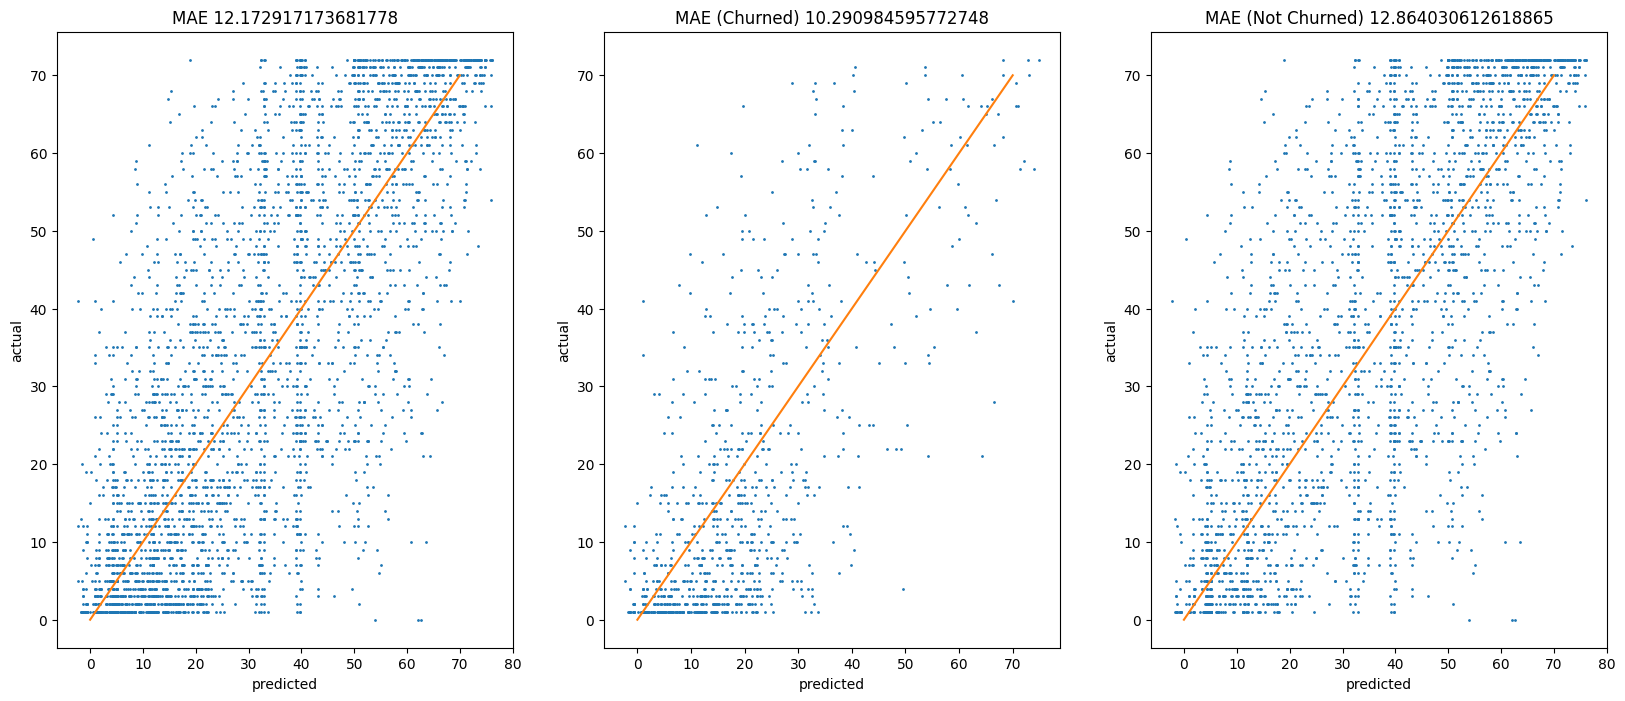

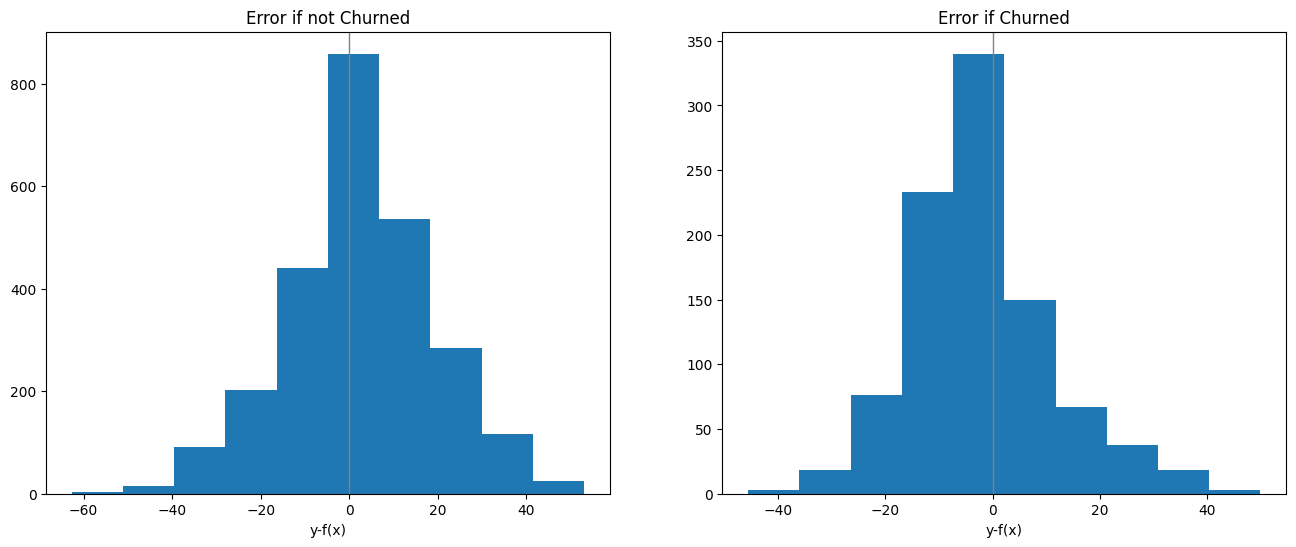

C-Index: 0.8237814036484075
Average Underestimated Survival (Churned): 11.149076776948796
Average Underestimated Survival (Not Churned): 13.682457719890273


In [35]:
print('Testing Performance')
plot_results(y_test, prediction_reg, z_test, save=False)
compute_metrics(y_test, prediction_reg, z_test)

# Kernelized Version

In [87]:
# sigma^2 to use for RBF Kernel
sigma2 = 1.5

In [89]:
# function to compute RBF Kernel Matrix between X1 and X2
def compute_rbf(X1, X2, sigma2=100):
    return np.exp(-((np.expand_dims(X2, 0)- np.expand_dims(X1, 1))**2).sum(axis=2)/(2*sigma2))


In [90]:
### YOUR CODE HERE
# Redefine matrix U V W
U = compute_rbf(X_comp, X_comp, sigma2) - compute_rbf(X_comp, X_comp_bar, sigma2) - \
    compute_rbf(X_comp_bar, X_comp, sigma2) + compute_rbf(X_comp_bar, X_comp_bar, sigma2)
V = compute_rbf(X_train, X_train, sigma2)
W = compute_rbf(X_train, X_comp, sigma2) - compute_rbf(X_train, X_comp_bar, sigma2)
tolerance = 1e-12

delta_y = y_comp - y_comp_bar

Q = np.block([
    [U, W.T],
    [W, V]
])


# quadratic program setup
alpha = cp.Variable(E)
beta = cp.Variable(n)
gamma = cp.Variable(n)
# initialize constraints
constraints = []

# Constant in the problem
r_1 = 100 / E
r_2 = 10000 / n
Z = np.diag(z_train)

# initialize constraints
constraints = []

constraints.append(cp.abs(cp.sum(beta-np.matmul(Z,gamma))) <= tolerance)

# add constraints for alpha
for i in range(E):
    constraints.append(alpha[i]>=tolerance)
    constraints.append(alpha[i]<=r_1)
    
# add constraints for beta and gamma
for i in range(n):  
    constraints.append(beta[i]>=tolerance)
    constraints.append(beta[i]<=r_2)
    constraints.append(gamma[i]>=tolerance)
    constraints.append(gamma[i]<=r_2)

### FORMULATE AND SOLVE DM
x = cp.hstack([alpha, beta - Z@gamma])

dy_y = np.hstack([delta_y, y_train])
objective = -cp.quad_form(x, cp.atoms.affine.wraps.psd_wrap(Q)) + dy_y.T @ (x)

objective = cp.Maximize(objective)

### FORMULATE AND SOLVE DM-KERNELIZED

prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=1)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 23 08:25:08 PM: Your problem has 10251 variables, 20503 constraints, and 0 parameters.
(CVXPY) Nov 23 08:25:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 23 08:25:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 23 08:25:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 23 08:25:09 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 23 08:25:09 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr

68141.20963152776

In [91]:
alpha = alpha.value
beta = beta.value
gamma = gamma.value

In [93]:
# Deduce b
idx = np.logical_or(beta>tolerance, np.logical_and(gamma>tolerance, z_train==1))
idx.sum()

2169

In [94]:
# remove X_i from X_comp if X_i is in the X_train[idx]
X_comp_process = []
X_comp_bar_process = []
alpha_process = []
# check = []

for i in range(X_comp.shape[0]):
    if any(np.array_equal(X_comp[i], x) for x in X_train[idx]):
        # check.append(i)
        X_comp_process.append(X_comp[i])
        X_comp_bar_process.append(X_comp_bar[i])
        alpha_process.append(alpha[i])
X_comp_process = np.array(X_comp_process)
X_comp_bar_process = np.array(X_comp_bar_process)
alpha_process = np.array(alpha_process)
Z_process = Z[:, idx][idx, :]


In [95]:
### YOUR CODE HERE

raw = alpha_process @ (compute_rbf(X_comp_process, X_train[idx], sigma2) - compute_rbf(X_comp_bar_process, X_train[idx], sigma2)) + \
    (beta[idx] - Z_process @ gamma[idx]) @ compute_rbf(X_train[idx], X_train[idx], sigma2)
b = np.mean(y_train[idx] - raw)
prediction_rbf = alpha_process @ (compute_rbf(X_comp_process, X_train, sigma2) - compute_rbf(X_comp_bar_process, X_train, sigma2)) + \
    (beta[idx] - Z_process @ gamma[idx]) @ compute_rbf(X_train[idx], X_train, sigma2)
### FIND THE PREDICTION ON THE TRAINING SET

In [45]:
# ### YOUR CODE HERE Does not calculate omega from support vectors

# raw = alpha @ (compute_rbf(X_comp, X_train, sigma2)) - alpha @ compute_rbf(X_comp_bar, X_train, sigma2) + \
#     (beta - Z @ gamma) @ compute_rbf(X_train, X_train, sigma2)
# b = np.mean(y_train - raw)
# prediction_rbf = alpha @ (compute_rbf(X_comp, X_train, sigma2)) - alpha @ compute_rbf(X_comp_bar, X_train, sigma2) + \
#     (beta - Z @ gamma) @ compute_rbf(X_train, X_train, sigma2)
# ### FIND THE PREDICTION ON THE TRAINING SET

Training Performance


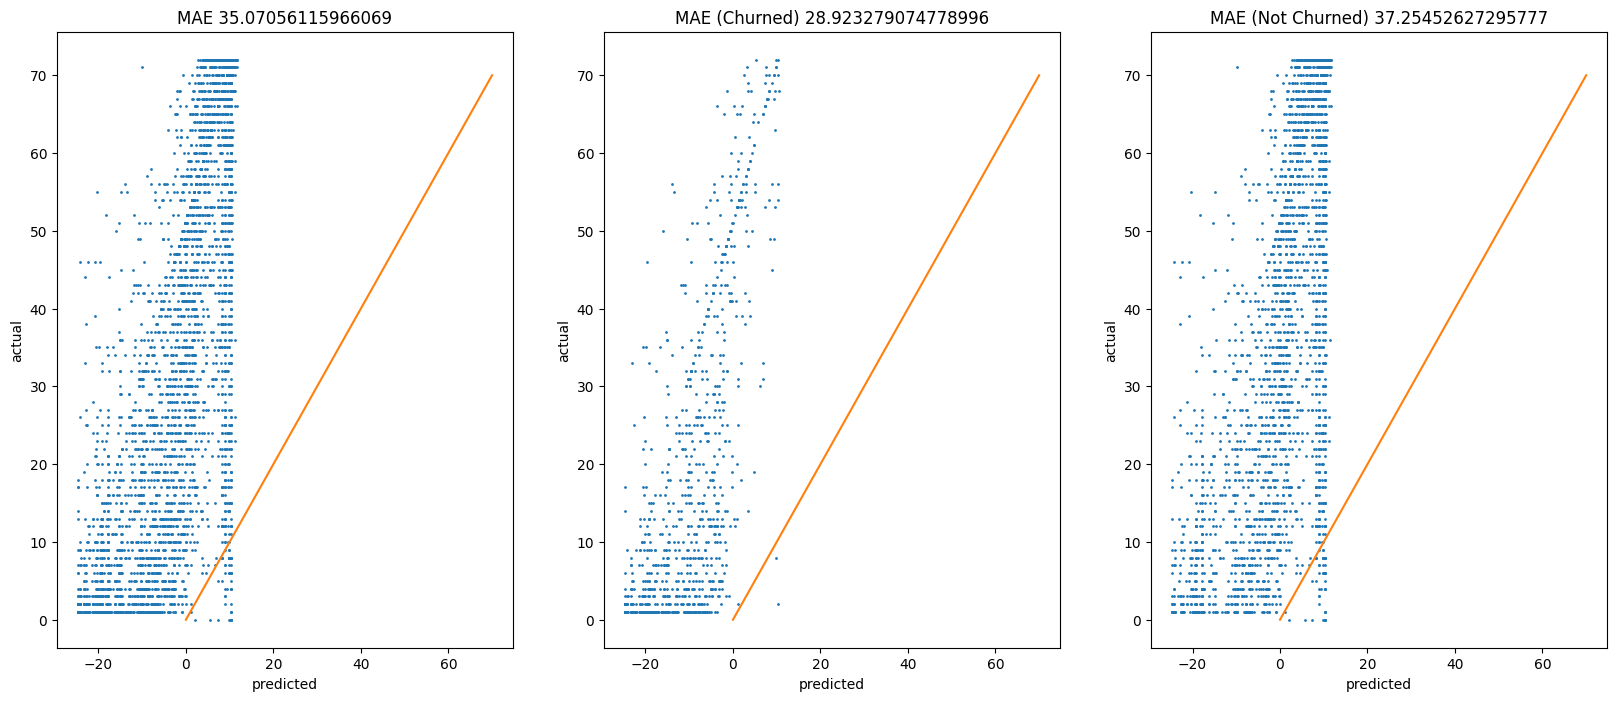

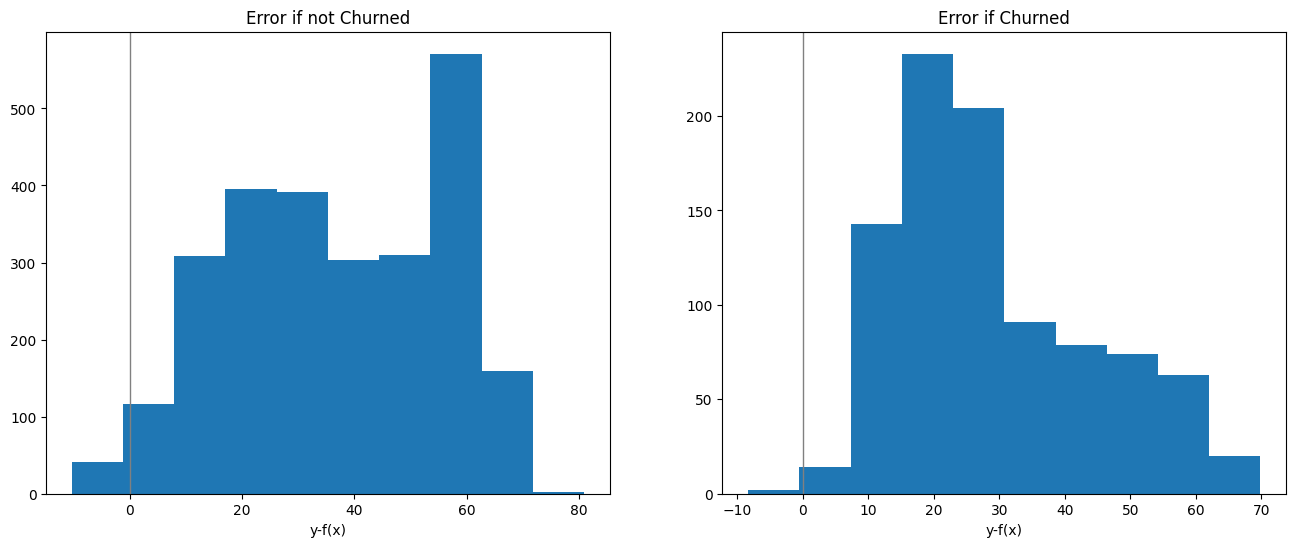

C-Index: 0.8701875302772208
Average Underestimated Survival (Churned): 28.974958644336915
Average Underestimated Survival (Not Churned): 37.87253838827739


In [96]:
print('Training Performance')
# training results
plot_results(y_train, prediction_rbf, z_train, save=False)
compute_metrics(y_train, prediction_rbf, z_train)

In [97]:
### YOUR CODE HERE

prediction_rbf = alpha_process @ compute_rbf(X_comp_process - X_comp_bar_process, X_test, sigma2) + (beta[idx] - Z_process @ gamma[idx]) @ compute_rbf(X_train[idx], X_test, sigma2) + b
prediction_rbf = alpha_process @ (compute_rbf(X_comp_process, X_test, sigma2) - compute_rbf(X_comp_bar_process, X_test, sigma2)) + \
    (beta[idx] - Z_process @ gamma[idx]) @ compute_rbf(X_train[idx], X_test, sigma2)
### FIND THE PREDICTION ON THE TEST SET

Testing Performance


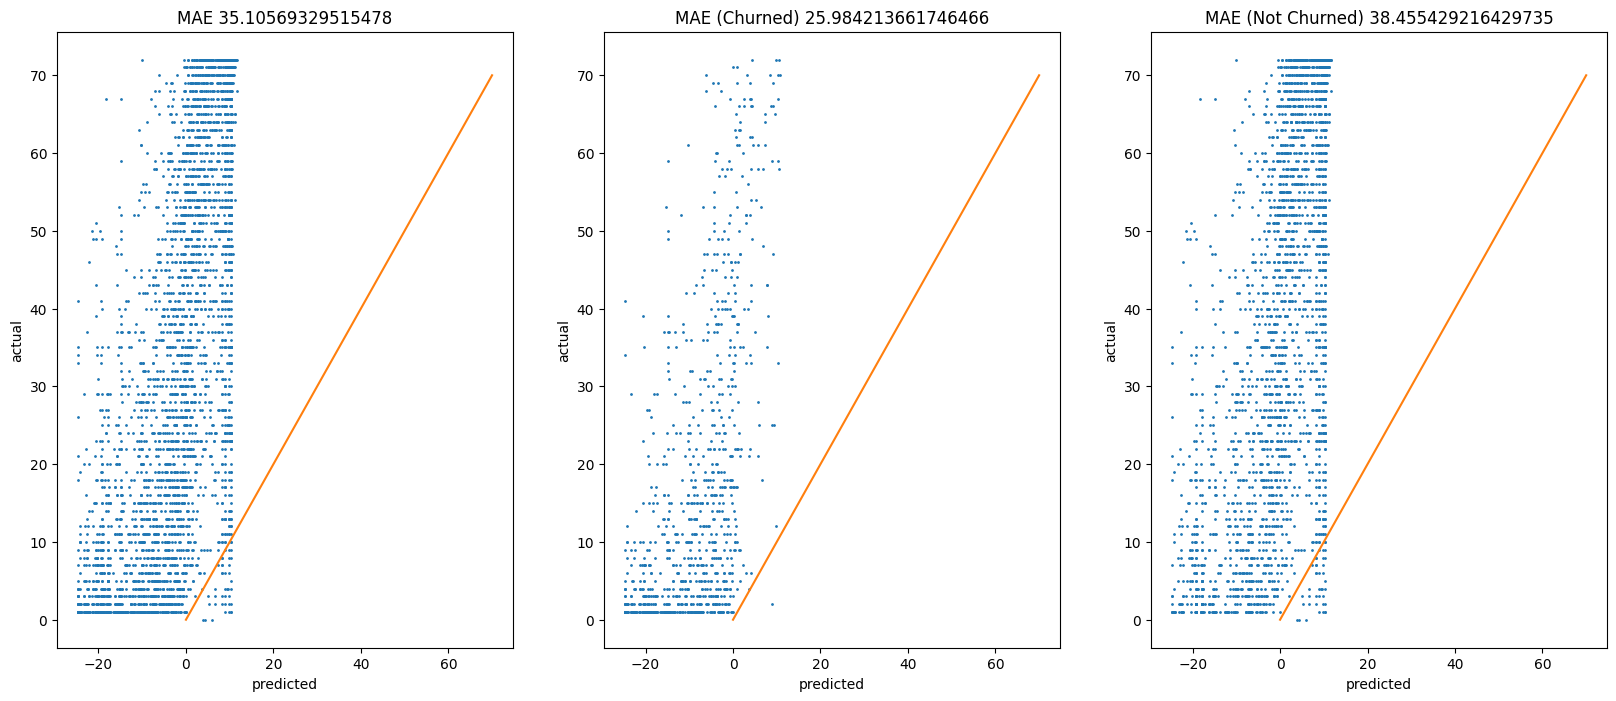

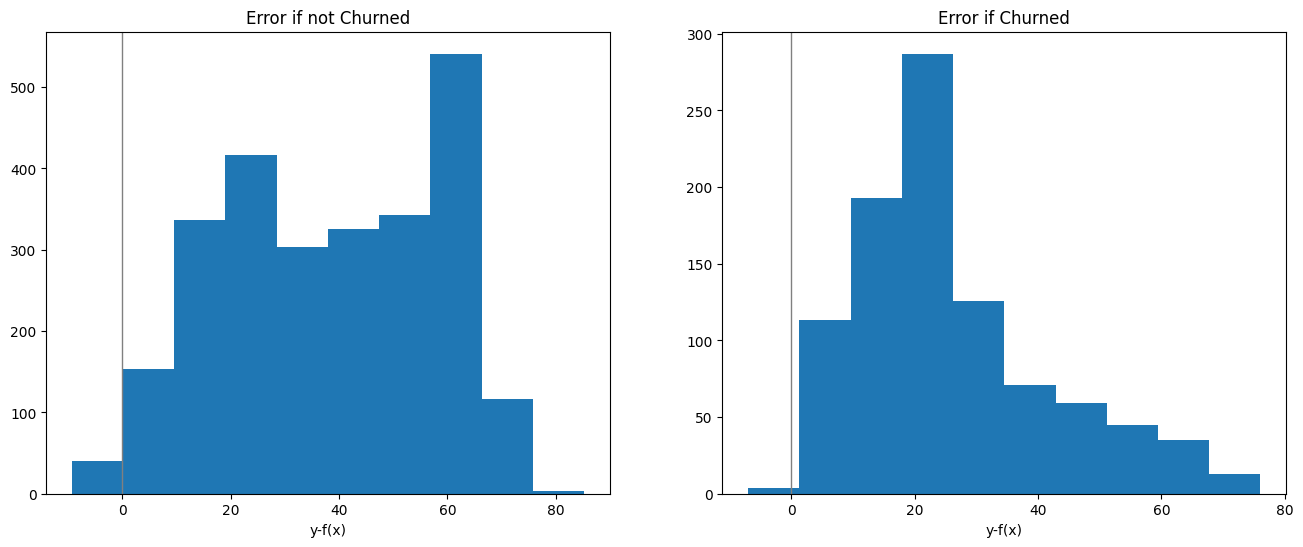

C-Index: 0.828230441052501
Average Underestimated Survival (Churned): 26.004285019043976
Average Underestimated Survival (Not Churned): 38.999261247409386


In [98]:
print('Testing Performance')
# testing results
plot_results(y_test, prediction_rbf, z_test, save=False)
compute_metrics(y_test, prediction_rbf, z_test)